C:\Users\Gabriel D. Barros\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


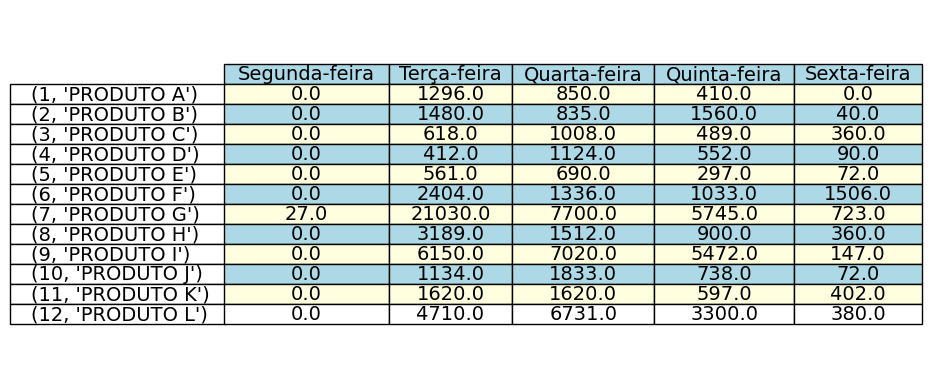

In [3]:
import pandas as pd
import pyodbc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

# Configuração da fonte de dados ODBC (DSN)
nome_dsn = 'xodo'  # Substitua pelo nome da sua DSN configurada
usuario = 'root'
senha = '@kalunga123'
banco_de_dados = 'xodo'  # Nome do seu banco de dados

# String de conexão ODBC
string_conexao_odbc = f'DSN={nome_dsn};UID={usuario};PWD={senha};DATABASE={banco_de_dados}'

# Conectar ao banco de dados MySQL via ODBC
conexao = pyodbc.connect(string_conexao_odbc)


# Consulta SQL ajustada para considerar automaticamente os últimos 1 meses a partir da data corrente
consulta_sql = f"""
SELECT ped_numero, ped_dtentrega, ipv_procodigo, pro_desc, SUM(ipv_propbruto) as peso_diario
FROM pedidos
JOIN itenspedido ON ped_numero = ipv_pednumero AND ped_spvcodigo = ipv_spvcodigo AND ped_filcodigo = ipv_filcodigo
JOIN produto ON ipv_procodigo = pro_codigo
JOIN enderecos ON end_pescodigo = ped_pescodigo AND end_codigo = ped_endentrega 
WHERE ped_dtentrega BETWEEN CURDATE() - INTERVAL 1 MONTH AND CURDATE()
AND ped_dtentrega != '2024-05-01'
AND (ped_natcodigo IN ('VE', 'BON', 'VIF', 'VIN', 'VTE', 'VTI', 'DEG'))
AND ped_stpcodigo NOT IN (7, 13)
GROUP BY ped_dtentrega, ipv_procodigo, pro_desc
ORDER BY ped_dtentrega;
"""

# Executar a consulta SQL e carregar os resultados em um DataFrame do Pandas
df = pd.read_sql(consulta_sql, conexao)

# Fechar a conexão com o banco de dados
conexao.close()

# Converter a coluna 'ped_dtentrega' para o tipo de data
df['ped_dtentrega'] = pd.to_datetime(df['ped_dtentrega'])

# dt.dayofweek é um atributo da biblioteca pandas que é usado para obter o dia da semana de uma data. 
# Ele retorna a série com o dia da semana representado como um número inteiro de 0 a 6. Sendo 0 segunda e 6 domingo.
df['ped_dtentrega'] = pd.to_datetime(df['ped_dtentrega'])
df['dia_da_semana'] = df['ped_dtentrega'].dt.dayofweek

# Mapeando os dias da semana com Segunda começando a semana
dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
df['dia_da_semana_nome'] = df['dia_da_semana'].map(dias)

# Convertendo 'dia_da_semana_nome' para uma categoria com ordem específica
df['dia_da_semana_nome'] = pd.Categorical(df['dia_da_semana_nome'], categories=['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo'], ordered=True)

# Agora agrupando por 'dia_da_semana_nome' para garantir a ordem correta
vendas_por_dia = df.groupby('dia_da_semana_nome')['peso_diario'].mean().reset_index()

# Cria um mapeamento para os códigos e nomes dos produtos
codigos = range(1, 14)
nomes = ['PRODUTO ' + chr(65 + i) for i in range(13)]  # chr(65) é 'A'

mapeamento_codigos = dict(zip(df['ipv_procodigo'].unique(), codigos))
mapeamento_nomes = dict(zip(df['pro_desc'].unique(), nomes))

# Aplica o mapeamento ao DataFrame
df['ipv_procodigo'] = df['ipv_procodigo'].map(mapeamento_codigos)
df['pro_desc'] = df['pro_desc'].map(mapeamento_nomes)

# Calcula a média de vendas por dia da semana para cada produto
pivot_media_df = df.pivot_table(index=['ipv_procodigo', 'pro_desc'], columns='dia_da_semana_nome', values='peso_diario', aggfunc='mean')

# Soma as médias de segunda-feira, sábado e domingo na coluna segunda-feira
pivot_media_df['Segunda-feira'] = pivot_media_df['Segunda-feira'] + pivot_media_df.get('Sábado', 0) + pivot_media_df.get('Domingo', 0)

# Remove as colunas de sábado e domingo
pivot_media_df = pivot_media_df.drop(columns=['Sábado', 'Domingo'], errors='ignore')

# Preenche os valores NaN com 0 após o cálculo da média
pivot_media_df = pivot_media_df.fillna(0)

# Renomeia os índices do DataFrame
pivot_media_df.index.names = ['Código do Produto', 'Descrição do Produto']

dias_ordenados = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira']

# Adiciona os dias que estão faltando no DataFrame
for dia in dias_ordenados:
    if dia not in pivot_media_df.columns:
        pivot_media_df[dia] = 0

# Agora reordena as colunas
pivot_media_df = pivot_media_df[dias_ordenados]

# Arredonda todos os valores para zero casas decimais
pivot_media_df = pivot_media_df.round(0)

# Cria a figura e o eixo para a tabela
fig, ax = plt.subplots(1, 1)  # Ajuste o tamanho da figura aqui

# Esconde os eixos
ax.axis('off')

# Cria a tabela
table = ax.table(cellText=pivot_media_df.values,
                 colLabels=pivot_media_df.columns,
                 rowLabels=pivot_media_df.index,
                 cellLoc = 'center', 
                 loc='center')

# Ajusta automaticamente o tamanho da tabela às dimensões do plot
table.auto_set_font_size(False)
table.set_fontsize(14) 
table.scale(1.2, 1.2)  

# Ajusta automaticamente a largura das colunas
table.auto_set_column_width(col=list(range(len(pivot_media_df.columns))))

# Adiciona linhas zebradas em cores diferentes
cellDict = table.get_celld()
for i in range(0,len(pivot_media_df.columns)):
    for j in range(0,len(pivot_media_df.index)):
        if j%2 == 0:
            cellDict[(j,i)].set_facecolor('lightblue')  
        else:
            cellDict[(j,i)].set_facecolor('lightyellow')  

plt.show()


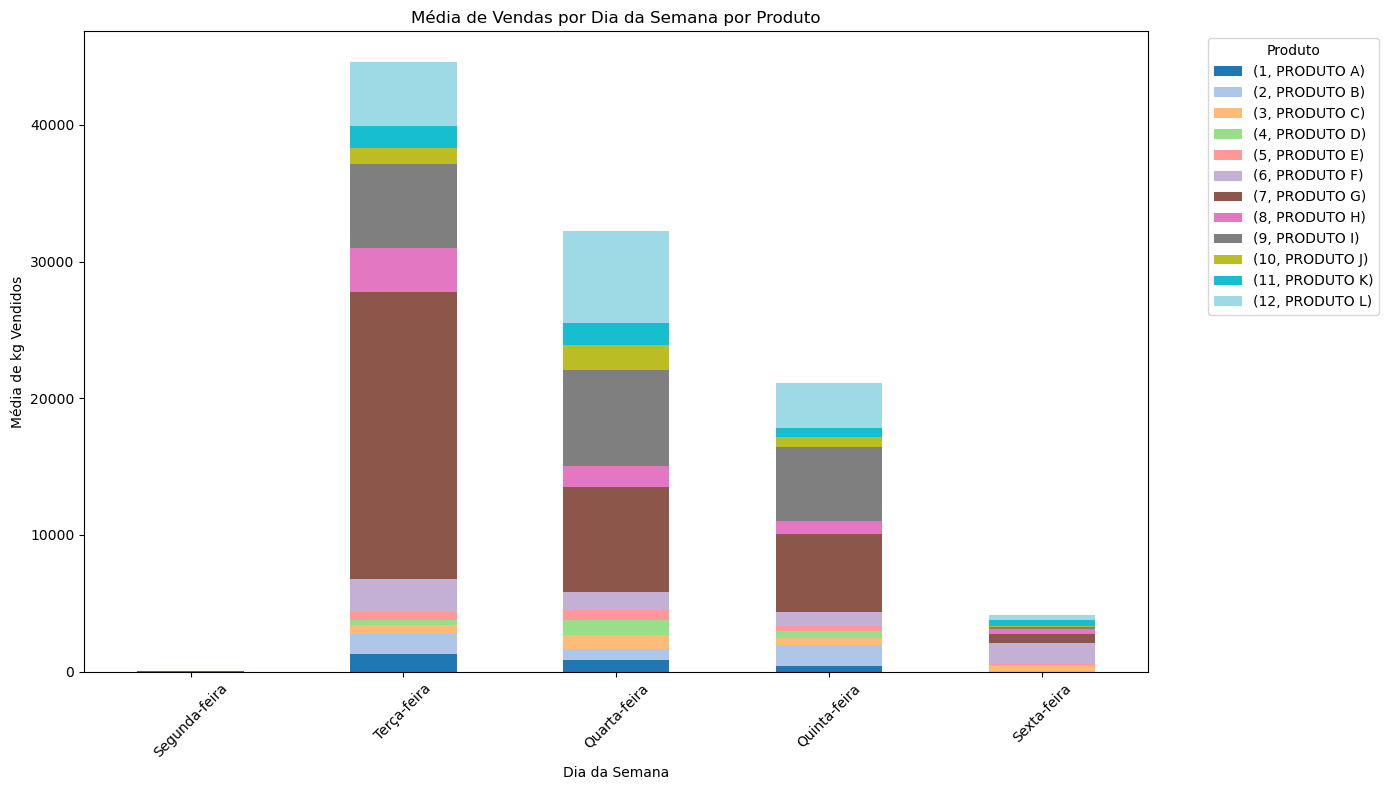

In [4]:
# Arredonda todos os valores para zero casas decimais
pivot_media_df = pivot_media_df.round(0)

# Plotar um gráfico de barras empilhadas com base na média
pivot_media_df.T.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.xlabel('Dia da Semana')
plt.ylabel('Média de kg Vendidos')
plt.title('Média de Vendas por Dia da Semana por Produto')
plt.xticks(rotation=45)
plt.legend(title='Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

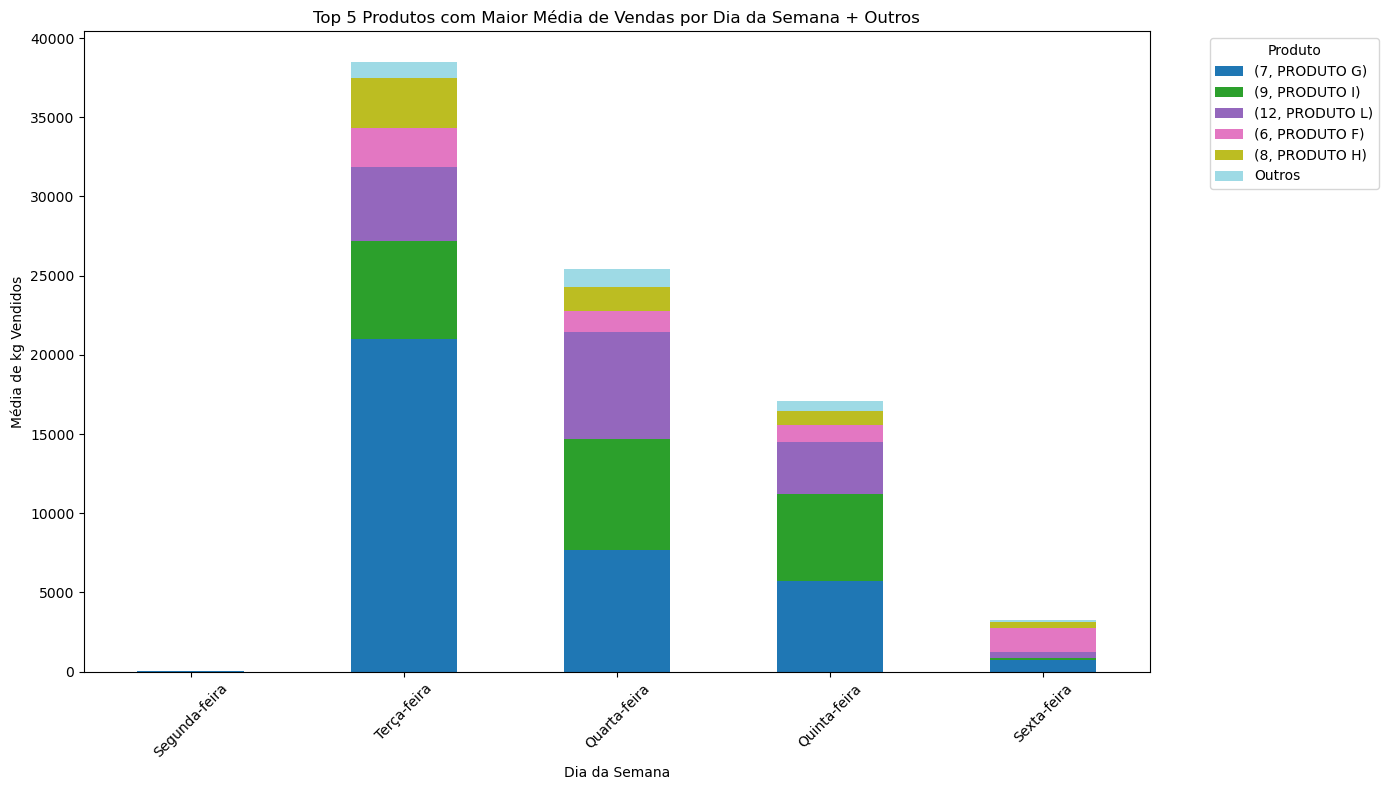

In [5]:
# Calcula a média total de vendas para cada produto
media_vendas_totais_por_produto = pivot_media_df.mean(axis=1)

# Seleciona os top 5 produtos com maior média de vendas para visualização
N = 5
top_media_produtos = media_vendas_totais_por_produto.nlargest(N).index

# Adiciona uma categoria "Outros" para os demais produtos com base na média
pivot_media_df_simplificado = pivot_media_df.loc[top_media_produtos]
pivot_media_df_simplificado.loc['Outros'] = pivot_media_df.drop(top_media_produtos).mean()

# Plotar um gráfico de barras empilhadas com base na média simplificada
pivot_media_df_simplificado.T.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.xlabel('Dia da Semana')
plt.ylabel('Média de kg Vendidos')
plt.title('Top 5 Produtos com Maior Média de Vendas por Dia da Semana + Outros')
plt.xticks(rotation=45)
plt.legend(title='Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [4]:
# Exporta o DataFrame para um arquivo Excel
pivot_media_df.to_excel('media_vendas_por_dia_arley1mes.xlsx')

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Codifica os produtos como números inteiros
df['pro_desc'] = df['pro_desc'].astype('category')
df['pro_desc_cat'] = df['pro_desc'].cat.codes

# Cria um DataFrame com os recursos que você deseja usar para prever a demanda
X = df[['pro_desc_cat', 'dia_da_semana']]

# Cria uma série com a variável que você deseja prever (a demanda)
y = df['peso_diario']

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cria e treina o modelo de floresta aleatória
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Faz previsões no conjunto de teste
previsoes = modelo.predict(X_test)

# Calcula o erro quadrático médio das previsões
erro = mean_squared_error(y_test, previsoes)
print(f'Erro Quadrático Médio: {erro}')


Erro Quadrático Médio: 1889140.3458708331


In [7]:
import numpy as np

rmse = np.sqrt(erro)
print(f'Raiz do Erro Quadrático Médio: {rmse}')


Raiz do Erro Quadrático Médio: 1374.4600197426018


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Obtém a lista de produtos únicos
produtos = df['pro_desc'].unique()

# Para cada produto na lista de produtos únicos
for produto in produtos:
    # Filtra o DataFrame para incluir apenas o produto específico e cria uma cópia
    df_produto = df[df['pro_desc'] == produto].copy()

    # Verifica se há dados suficientes para dividir em conjuntos de treino e teste
    if len(df_produto) > 1:
        # Codifica os produtos como números inteiros
        df_produto['pro_desc_cat'] = df_produto['pro_desc'].astype('category').cat.codes

        # Cria um DataFrame com os recursos que você deseja usar para prever a demanda
        X = df_produto[['pro_desc_cat', 'dia_da_semana']]

        # Cria uma série com a variável que você deseja prever (a demanda)
        y = df_produto['peso_diario']

        # Divide os dados em conjuntos de treino e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Cria e treina o modelo de floresta aleatória
        modelo = RandomForestRegressor(n_estimators=100, random_state=42)
        modelo.fit(X_train, y_train)

        # Faz previsões no conjunto de teste
        previsoes = modelo.predict(X_test)

        # Calcula o erro quadrático médio das previsões
        erro = mean_squared_error(y_test, previsoes)
        rmse = np.sqrt(erro)
        print(f'Produto: {produto}, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: {rmse}')
    else:
        print(f'Produto: {produto}, não há dados suficientes para treinar o modelo.')


Produto: PRODUTO A, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 542.8
Produto: PRODUTO B, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 595.4000000000001
Produto: PRODUTO C, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 428.70000000000005
Produto: PRODUTO D, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 1628.0465105917583
Produto: PRODUTO E, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 227.37
Produto: PRODUTO F, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 1533.6560074866854
Produto: PRODUTO G, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 16467.434178717704
Produto: PRODUTO H, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 894.6300000000001
Produto: PRODUTO I, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 1359.9899999999998
Produto: PRODUTO J, Raiz do Erro Quadrático Médio do Modelo de Floresta Aleatória: 862.98
Produto: PRODUTO K,

In [11]:
# Modelo de Persistência para Comparação

# Obtém a lista de produtos únicos
produtos = df['pro_desc'].unique()

# Para cada produto na lista de produtos únicos
for produto in produtos:
    # Filtra o DataFrame para incluir apenas o produto específico
    df_produto = df[df['pro_desc'] == produto]

    # Agrega os dados por dia
    df_produto = df_produto.groupby('ped_dtentrega')['peso_diario'].sum()

    # Divide os dados em conjunto de treino e teste
    tamanho_treino = int(len(df_produto) * 0.8)
    treino, teste = df_produto[0:tamanho_treino], df_produto[tamanho_treino:len(df_produto)]

    # Verifica se 'treino' não está vazio
    if len(treino) > 0:
        # Cria as previsões usando o modelo de persistência
        previsoes = [treino[-1]] * len(teste)

        # Calcula o erro quadrático médio das previsões
        erro = mean_squared_error(teste, previsoes)
        
        # Calcula a raiz do erro quadrático médio
        rmse = np.sqrt(erro)
        
        print(f'Produto: {produto}, Raiz do Erro Quadrático Médio do Modelo de Persistência: {rmse}')
    else:
        print(f'Produto: {produto}, não há dados suficientes para treinar o modelo.')


Produto: PRODUTO A, Raiz do Erro Quadrático Médio do Modelo de Persistência: 440.0
Produto: PRODUTO B, Raiz do Erro Quadrático Médio do Modelo de Persistência: 1520.0
Produto: PRODUTO C, Raiz do Erro Quadrático Médio do Modelo de Persistência: 258.0
Produto: PRODUTO D, Raiz do Erro Quadrático Médio do Modelo de Persistência: 70.89781378857884
Produto: PRODUTO E, Raiz do Erro Quadrático Médio do Modelo de Persistência: 225.0
Produto: PRODUTO F, Raiz do Erro Quadrático Médio do Modelo de Persistência: 8.48528137423857
Produto: PRODUTO G, Raiz do Erro Quadrático Médio do Modelo de Persistência: 0.0
Produto: PRODUTO H, Raiz do Erro Quadrático Médio do Modelo de Persistência: 540.0
Produto: PRODUTO I, Raiz do Erro Quadrático Médio do Modelo de Persistência: 5325.0
Produto: PRODUTO J, Raiz do Erro Quadrático Médio do Modelo de Persistência: 666.0
Produto: PRODUTO K, Raiz do Erro Quadrático Médio do Modelo de Persistência: 195.0
Produto: PRODUTO L, Raiz do Erro Quadrático Médio do Modelo de P